In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration

gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=1200)])
print(len(gpus), "Physical GPUs")

2023-03-10 19:12:35.153849: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


1 Physical GPUs


2023-03-10 19:12:37.022014: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-10 19:12:37.022654: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-10 19:12:37.063642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 19:12:37.063777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-03-10 19:12:37.063806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-10 19:12:37.097709: I tensorflow/stream_executor/platform/def

In [2]:
grb = ["2021-08-07_10-05-18_exp4s_sbin4/ch0/part1/rate_multi_ch.txt",
"2021-08-22_09-16-56_exp4s_sbin4/ch0/part1/rate_multi_ch.txt",
"2021-09-09_09-25-05_exp4s_sbin4/ch0/part2/rate_multi_ch.txt",
"2021-10-18_22-22-36_exp1s_sbin4/ch0/part1/rate_multi_ch.txt",
"2021-10-18_22-22-36_exp1s_sbin4/ch0/part2/rate_multi_ch.txt"]

#uno = glob.glob("Data/GRBalpha/Data_firmware_2/*-*-*_*-*-*_exp*s_sbin*/ch0/part*/rate_multi_ch.txt")
dos = glob.glob("Data/GRBalpha/Data_firmware_3/*-*-*_*-*-*_exp*s_sbin*/ch0/rate_multi_ch.txt")
data = np.sort(dos)
X = []
fill = []
for fname in data:
    if fname in grb:
        skip
    else:
        with open(fname) as file:
            fill.append(fname)
            lines = file.readlines()
            for line in lines[9:]:
                split = line[:-1].split()
                X.append([float(split[7]),float(split[8]),np.log10(float(split[-1])+1)])
                


            

print("Number of files:",len(data))
print("Number of points:",len(X))

df = pd.DataFrame(data = X, columns=["log","lat","rate"])
df

Number of files: 54
Number of points: 463779


,log,lat,rate
0,354.1160,48.1902,2.193820
1,354.0260,47.9446,2.186815
2,353.9370,47.6989,2.183981
3,353.8490,47.4532,2.203441
4,353.7610,47.2074,2.163609
...,...,...,...
463774,82.9377,-54.1543,3.013680
463775,82.9098,-54.2151,2.993877
463776,82.8819,-54.2759,2.980912
463777,82.8539,-54.3368,2.984527


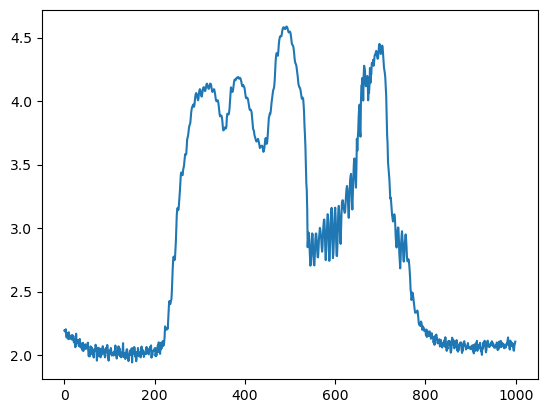

In [3]:
plt.plot(df["rate"][0:1000])

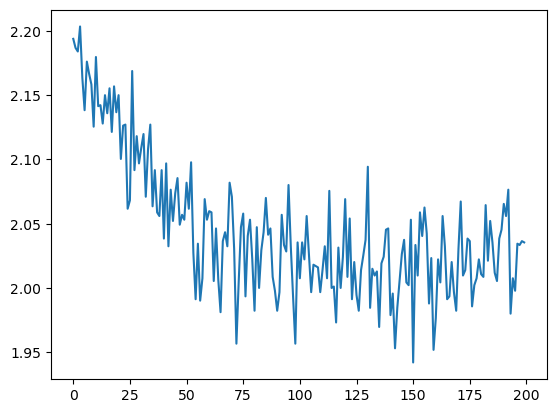

In [4]:
plt.plot(df["rate"][0:200])

In [5]:
df['rate'].to_numpy()

array([2.19382003, 2.18681512, 2.18398122, ..., 2.98091194, 2.98452731,
       2.59988307])

In [6]:
def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X,y = [], []
  for i in range(len(df_as_np)-window_size):
    X.append(df_as_np[i:i+window_size])
    y.append(df['rate'][i+window_size])
  return np.array(X), np.array(y)

In [7]:
WINDOW_SIZE = 250
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((463529, 250, 3), (463529,))

In [8]:
X_train, y_train, X_test, y_test = X1[0:400000],y1[0:400000],X1[400000:],y1[400000:]

In [9]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 3)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17408     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,937
Trainable params: 17,937
Non-trainable params: 0
_________________________________________________________________


2023-03-10 19:12:42.618226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 19:12:42.618541: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-10 19:12:42.618696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 19:12:42.618870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84Gi

In [10]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

2023-03-10 19:12:43.536396: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1200000000 exceeds 10% of free system memory.
2023-03-10 19:12:44.021347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-10 19:12:44.021693: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3392160000 Hz


Epoch 1/5


2023-03-10 19:12:44.920483: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-10 19:12:45.109351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


12500/12500 [==============================] - 85s 7ms/step - loss: 0.9807 - root_mean_squared_error: 0.8747 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0716
Epoch 2/5
12500/12500 [==============================] - 83s 7ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 3/5
12500/12500 [==============================] - 83s 7ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0506
Epoch 4/5
12500/12500 [==============================] - 85s 7ms/step - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 5/5
12500/12500 [==============================] - 84s 7ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482


# GRBalpha (true) detections

In [11]:
X_grb = []


uno = glob.glob("Data/GRBalpha/Data_firmware_2/*-*-*_*-*-*_exp*s_sbin*/ch0/part*/rate_multi_ch.txt")
for fname in uno:
    with open(fname) as file:
        lines = file.readlines()
        for line in lines[9:]:
            print(line)
            split = line[:-1].split()
            X_grb.append([float(split[7]),float(split[8]),np.log10(float(split[-1])+1)])


df_grb = pd.DataFrame(data = X_grb, columns=["log","lat","rate"])
df_grb

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




     377      12118   2022-07-29 09:06:39   2022-07-29 09:06:43                 12054      206.335      6.96051      559.620      206.285      6.71098      559.649      4.00000       4        5013      7.34375      7.37500      255.000      206.000      84.0000      1.00000      63.7500      51.5000      21.0000     0.250000      546.000      136.500

     378      12119   2022-07-29 09:06:43   2022-07-29 09:06:47                 12058      206.285      6.71098      559.649      206.235      6.46145      559.679      4.00000       4        5013      7.34375      7.37500      284.000      189.000      52.0000      0.00000      71.0000      47.2500      13.0000      0.00000      525.000      131.250

     379      12120   2022-07-29 09:06:47   2022-07-29 09:06:51                 12062      206.235      6.46145      559.679      206.185      6.21193      559.708      4.00000       4        5013      7.34375      7.37500      237.000      200.000      64.0000      0.00000      59.2500    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,log,lat,rate
0,260.668,59.3377,3.736914
1,260.525,59.5798,3.824971
2,260.380,59.8218,3.714791
3,260.233,60.0636,3.720717
4,260.084,60.3053,3.680789
...,...,...,...
173204,313.964,-64.5247,2.976235
173205,313.770,-64.7613,3.080717
173206,313.573,-64.9978,3.074359
173207,313.372,-65.2340,3.012837


In [12]:
WINDOW_SIZE = 250
X1, y1 = df_to_X_y(df_grb, WINDOW_SIZE)
test_predictions = model1.predict(X1).flatten()
pred = 10**test_predictions
truee = 10**y1

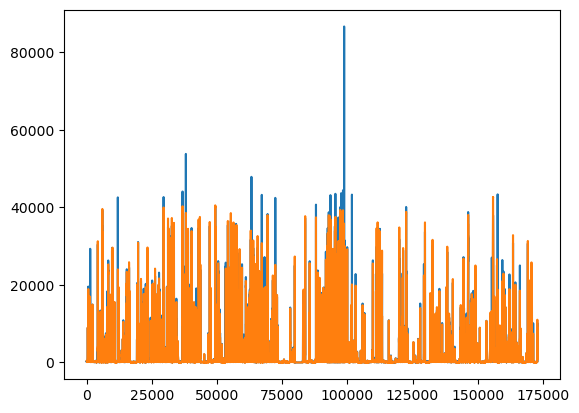

In [13]:
plt.plot(pred)
plt.plot(truee)

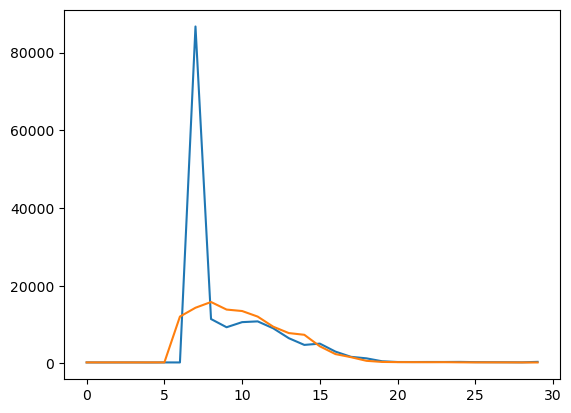

In [29]:
plt.plot(pred[98770:98800])
plt.plot(truee[98770:98800])

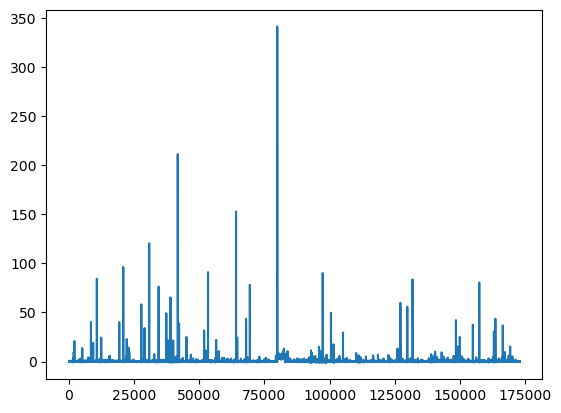

In [21]:
acc = (pred-truee)/truee
plt.plot(acc)